# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Baseline Models

Today we work on the simplest models to act as a starting point that we will beat.

In [190]:
# imports

import os
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter

In [191]:
# More imports for our traditional machine learning

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

## NLP imports

In the next cell, we have more imports for our NLP related machine learning.  
If the gensim import gives you an error like "Cannot import name 'triu' from 'scipy.linalg' then please run in another cell:  
`!pip install "scipy<1.13"`  
As described on StackOverflow [here](https://stackoverflow.com/questions/78279136/importerror-cannot-import-name-triu-from-scipy-linalg-when-importing-gens).  
Many thanks to students Arnaldo G and Ard V for sorting this.

In [192]:
# NLP related imports

from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [193]:
# Finally, more imports for more advanced machine learning

from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

In [194]:
# Constants - used for printing to stdout in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [195]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [196]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [197]:
%matplotlib inline

# Loading the pkl files

Let's avoid curating all our data again! Load in the pickle files


In [198]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [199]:
# Remind ourselves the training prompt

print(train[0].prompt)

How would you classify this sensor data - normal or anomalous?

[{"timestamp": 1737806400, "room": "pillbox", "nodeId": 1, "onOff": true}, {"timestamp": 1737806460, "room": "bedroom", "nodeId": 2, "onOff": true}, {"timestamp": 1737806700, "room": "bathroom", "nodeId": 2, "onOff": true}, {"timestamp": 1737807000, "room": "bathroom", "nodeId": 3, "humidity": 6500}, {"timestamp": 1737807300, "room": "bathroom", "nodeId": 2, "onOff": false}, {"timestamp": 1737807600, "room": "

Result is normal


In [202]:
# Remind ourselves the details

print(test[0])

<$anomalous>


In [203]:
# Remind a test prompt

train[0]

<$normal>

## Unveiling a mighty script that we will use a lot!

A rather pleasing Test Harness that will evaluate any model against the items from the Test set

And show us the results in a visually satisfying way.

You write a function of this form:

```
def my_prediction_function(item):
    # my code here
    return my_estimate
```

And then you call:

`Tester.test(my_prediction_function)`

To evaluate your model.

In [222]:
class Tester:

    def __init__(self, predictor, data, title=None, size=80):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.colors = []

    def color_for(self, error, truth):
        if not error:
            return "green"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.result
        error = guess != truth
        color = self.color_for(error, truth)
        prompt = datapoint.prompt if len(datapoint.prompt) <= 40 else datapoint.prompt[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.colors.append(color)
        #print(f"{COLOR_MAP[color]}{i+1}: Guess: {guess} Truth: {truth:} Error: {error:} Item: {prompt}{RESET}")
        print(f"{COLOR_MAP[color]}{i+1}: Guess: {guess} Truth: {truth:} Error: {error:}{RESET}")

    def chart(self, title):
        actual = self.truths
        predicted = self.guesses

        # Get unique classes
        classes = list(set(actual + predicted))  # Union of unique classes in actual and predicted

        # Initialize the confusion matrix as a dictionary
        confusion_matrix = {true: {pred: 0 for pred in classes} for true in classes}

        # Populate the confusion matrix
        for a, p in zip(actual, predicted):
            confusion_matrix[a][p] += 1

        # Convert the confusion matrix into a 2D list for visualization
        matrix = [[confusion_matrix[true][pred] for pred in classes] for true in classes]

        # Plot the confusion matrix
        plt.figure(figsize=(8, 6))
        plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(title)
        plt.colorbar()

        # Add labels
        tick_marks = range(len(classes))
        plt.xticks(tick_marks, classes)
        plt.yticks(tick_marks, classes)
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')

        # Add text annotations
        for i in range(len(classes)):
            for j in range(len(classes)):
                plt.text(j, i, matrix[i][j],
                        horizontalalignment="center",
                        color="white" if matrix[i][j] > max(max(row) for row in matrix) / 2 else "black")

        plt.tight_layout()
        plt.show()


    def report(self):
        average_error = sum(self.errors) / self.size
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error={average_error:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

SyntaxError: invalid syntax (2808863601.py, line 14)

# Now for something basic

What's the very simplest model you could imagine?

Let's start with a random guess - either normal or anomalous!

In [223]:
def random_situation_assessor(item):
    choices = ['normal', 'anomalous']
    choiceNum = random.randint(0,1)
    choice = choices[choiceNum]  
    return choice

In [219]:
print(random_situation_assessor(train[1]))

anomalous


1: Guess: normal Truth: normal Error: False
2: Guess: normal Truth: normal Error: False
3: Guess: anomalous Truth: anomalous Error: False
4: Guess: normal Truth: normal Error: False
5: Guess: normal Truth: anomalous Error: True
6: Guess: normal Truth: anomalous Error: True
7: Guess: normal Truth: normal Error: False
8: Guess: normal Truth: anomalous Error: True
9: Guess: anomalous Truth: normal Error: True
10: Guess: normal Truth: anomalous Error: True
11: Guess: normal Truth: anomalous Error: True
12: Guess: normal Truth: normal Error: False
13: Guess: normal Truth: anomalous Error: True
14: Guess: normal Truth: anomalous Error: True
15: Guess: normal Truth: anomalous Error: True
16: Guess: normal Truth: normal Error: False
17: Guess: anomalous Truth: normal Error: True
18: Guess: normal Truth: anomalous Error: True
19: Guess: anomalous Truth: anomalous Error: False
20: Guess: anomalous Truth: normal Error: True
21: Guess: normal Truth: normal Error: False
22: Guess: normal Truth: nor

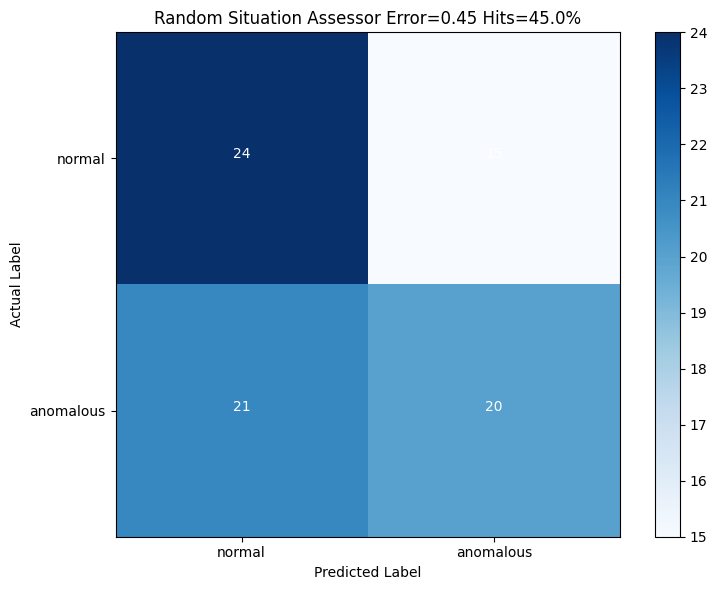

In [220]:
# Set the random seed

random.seed(42)

# Run our TestRunner
Tester.test(random_situation_assessor, train)

In [21]:
# Now some janky code to pluck out the Item Weight
# Don't worry too much about this: spoiler alert, it's not going to be much use in training!

def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [22]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

In [23]:
average_weight = sum(weights)/len(weights)
average_weight

13.57055237029551

In [24]:
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight

In [25]:
def get_rank(item):
    rank_dict = item.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None

In [26]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks)/len(ranks)
average_rank

380638.258828069

In [27]:
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

In [28]:
def get_text_length(item):
    return len(item.test_prompt())

In [48]:
def country_of_origin_is_china(item):
    if item.features.get('Country of Origin') == 'China':
        return 1
    else:
        return 0

In [29]:
# investigate the brands

brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1

# Look at most common 40 brands

brands.most_common(40)

[('HP', 5500),
 ('Power Stop', 3594),
 ('Dell', 3254),
 ('Detroit Axle', 2734),
 ('Lenovo', 2441),
 ('Dorman', 2116),
 ('SAMSUNG', 1772),
 ('BUYAUTOPARTS!', 1715),
 ('ACDelco', 1609),
 ('Evan Fischer', 1415),
 ('ASUS', 1387),
 ('Sony', 1282),
 ('Canon', 1201),
 ('Callahan BRAKE PARTS', 1154),
 ('Kohler', 1152),
 ('CURT', 1120),
 ('R1 Concepts', 1054),
 ('Rareelectrical', 966),
 ('Coverking', 941),
 ('Garage-Pro', 888),
 ('Kingston Brass', 852),
 ('Spectra Premium', 834),
 ('Moen', 829),
 ('Auto Dynasty', 824),
 ('WeatherTech', 822),
 ('DELTA FAUCET', 811),
 ('Generic', 793),
 ('Apple', 783),
 ('Cardone', 765),
 ('APS', 763),
 ('K&N', 758),
 ('GM', 743),
 ('Walker', 732),
 ('EBC Brakes', 717),
 ('AKKON', 646),
 ('SPEC-D TUNING', 626),
 ('TYC', 626),
 ('Covercraft', 618),
 ('Intel', 610),
 ('A-Premium', 607)]

In [30]:
TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]
def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

In [52]:
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0,
        "is_chinese": country_of_origin_is_china(item)
    }

In [53]:
# Look at features in a training item
get_features(train[9000])

{'weight': 56.0,
 'rank': 174503.5,
 'text_length': 840,
 'is_top_electronics_brand': 0,
 'is_chinese': 1}

In [54]:
# A utility function to convert our features into a pandas dataframe

def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

In [56]:
# Traditional Linear Regression!

np.random.seed(42)

# Separate features and target
feature_columns = ['weight', 'rank', 'text_length', 'is_top_electronics_brand','is_chinese']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# Train a Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# Predict the test set and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

weight: 0.2663098766460396
rank: 5.08557619705454e-05
text_length: 0.011685295616100889
is_top_electronics_brand: 195.12510096469674
is_chinese: -17.577347874967053
Intercept: 182.73221079716183
Mean Squared Error: 33250.5163297445
R-squared Score: 0.08496658571890203


In [57]:
# Function to predict price for a new item

def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

1: Guess: $231.91 Truth: $374.41 Error: $142.50 SLE: 0.23 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $199.63 Truth: $225.11 Error: $25.48 SLE: 0.01 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $177.06 Truth: $61.68 Error: $115.38 SLE: 1.09 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $390.63 Truth: $599.99 Error: $209.36 SLE: 0.18 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $214.60 Truth: $16.99 Error: $197.61 SLE: 6.17 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $214.71 Truth: $31.99 Error: $182.72 SLE: 3.53 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $194.88 Truth: $101.79 Error: $93.09 SLE: 0.42 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $193.41 Truth: $289.00 Error: $95.59 SLE: 0.16 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $206.46 Truth: $635.86 Error: $429.40 SLE: 1.26 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $185.58 Truth: $65.99 Error: $119.59 S

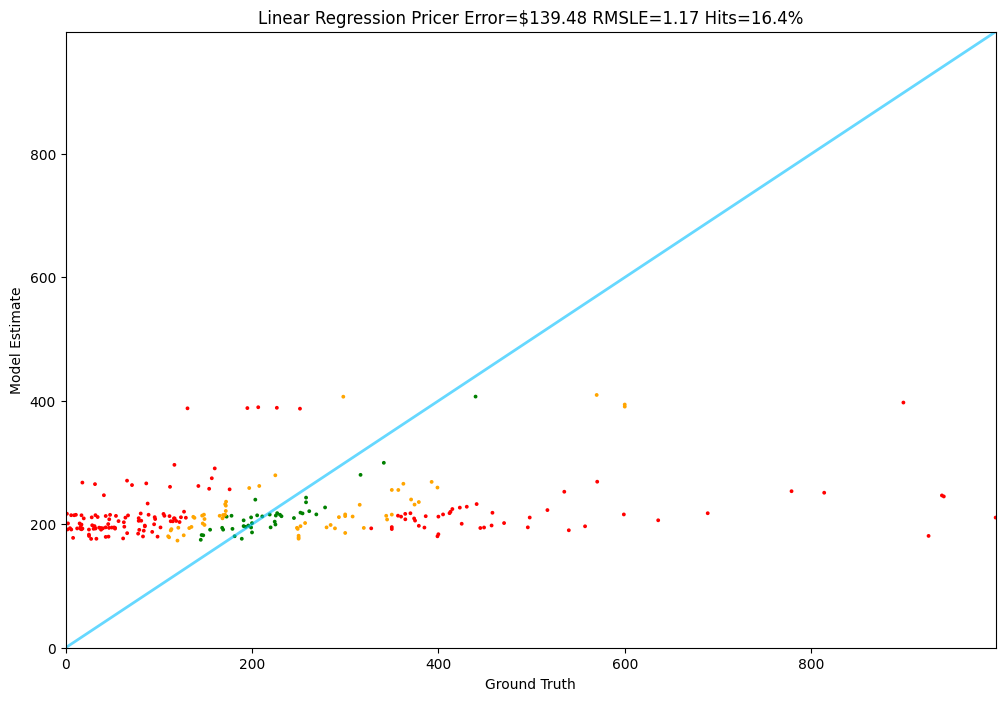

In [58]:
# test it

Tester.test(linear_regression_pricer)

In [59]:
# For the next few models, we prepare our documents and prices
# Note that we use the test prompt for the documents, otherwise we'll reveal the answer!!

prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [60]:
# Use the CountVectorizer for a Bag of Words model

np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

LinearRegression()

In [61]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Guess: $296.58 Truth: $374.41 Error: $77.83 SLE: 0.05 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $165.14 Truth: $225.11 Error: $59.97 SLE: 0.09 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $162.26 Truth: $61.68 Error: $100.58 SLE: 0.92 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $326.14 Truth: $599.99 Error: $273.85 SLE: 0.37 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $51.69 Truth: $16.99 Error: $34.70 SLE: 1.15 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $74.06 Truth: $31.99 Error: $42.07 SLE: 0.68 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $344.82 Truth: $101.79 Error: $243.03 SLE: 1.47 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $241.39 Truth: $289.00 Error: $47.61 SLE: 0.03 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $404.56 Truth: $635.86 Error: $231.30 SLE: 0.20 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $111.12 Truth: $65.99 Error: $45.13 SLE: 0

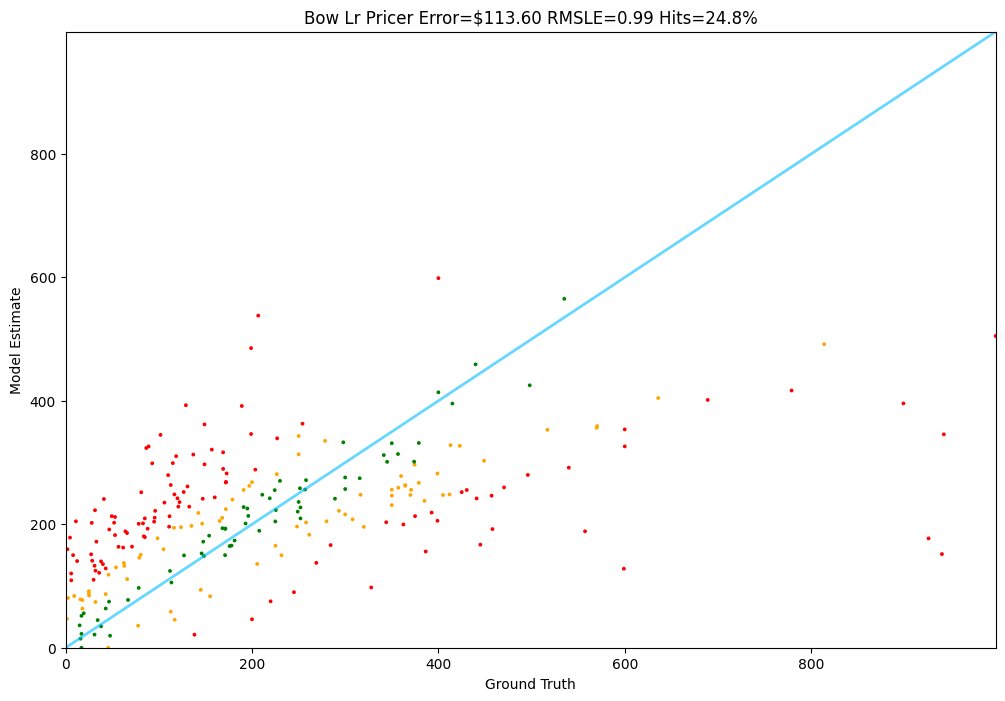

In [62]:
# test it

Tester.test(bow_lr_pricer)

In [63]:
# The amazing word2vec model, implemented in gensim NLP library

np.random.seed(42)

# Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [64]:
# This step of averaging vectors across the document is a weakness in our approach

def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

In [65]:
# Run Linear Regression on word2vec

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

LinearRegression()

In [66]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

1: Guess: $240.89 Truth: $374.41 Error: $133.52 SLE: 0.19 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $160.26 Truth: $225.11 Error: $64.85 SLE: 0.11 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $146.82 Truth: $61.68 Error: $85.14 SLE: 0.74 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $356.76 Truth: $599.99 Error: $243.23 SLE: 0.27 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $90.47 Truth: $16.99 Error: $73.48 SLE: 2.64 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $0.00 Truth: $31.99 Error: $31.99 SLE: 12.22 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $302.17 Truth: $101.79 Error: $200.38 SLE: 1.17 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $252.65 Truth: $289.00 Error: $36.35 SLE: 0.02 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $353.84 Truth: $635.86 Error: $282.02 SLE: 0.34 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $129.15 Truth: $65.99 Error: $63.16 SLE: 0

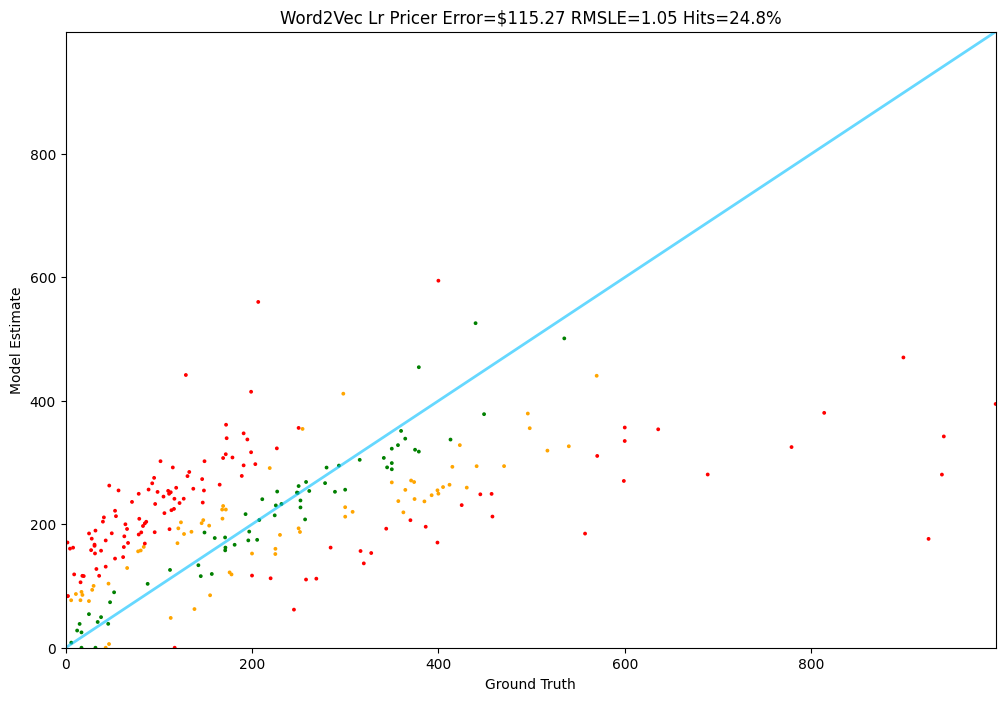

In [67]:
Tester.test(word2vec_lr_pricer)

In [68]:
# Support Vector Machines

np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)

LinearSVR()

In [69]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

1: Guess: $246.51 Truth: $374.41 Error: $127.90 SLE: 0.17 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $168.97 Truth: $225.11 Error: $56.14 SLE: 0.08 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $142.40 Truth: $61.68 Error: $80.72 SLE: 0.68 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $300.53 Truth: $599.99 Error: $299.46 SLE: 0.48 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $74.31 Truth: $16.99 Error: $57.32 SLE: 2.05 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $0.00 Truth: $31.99 Error: $31.99 SLE: 12.22 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $239.94 Truth: $101.79 Error: $138.15 SLE: 0.73 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $194.11 Truth: $289.00 Error: $94.89 SLE: 0.16 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $304.70 Truth: $635.86 Error: $331.16 SLE: 0.54 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $101.19 Truth: $65.99 Error: $35.20 SLE: 0

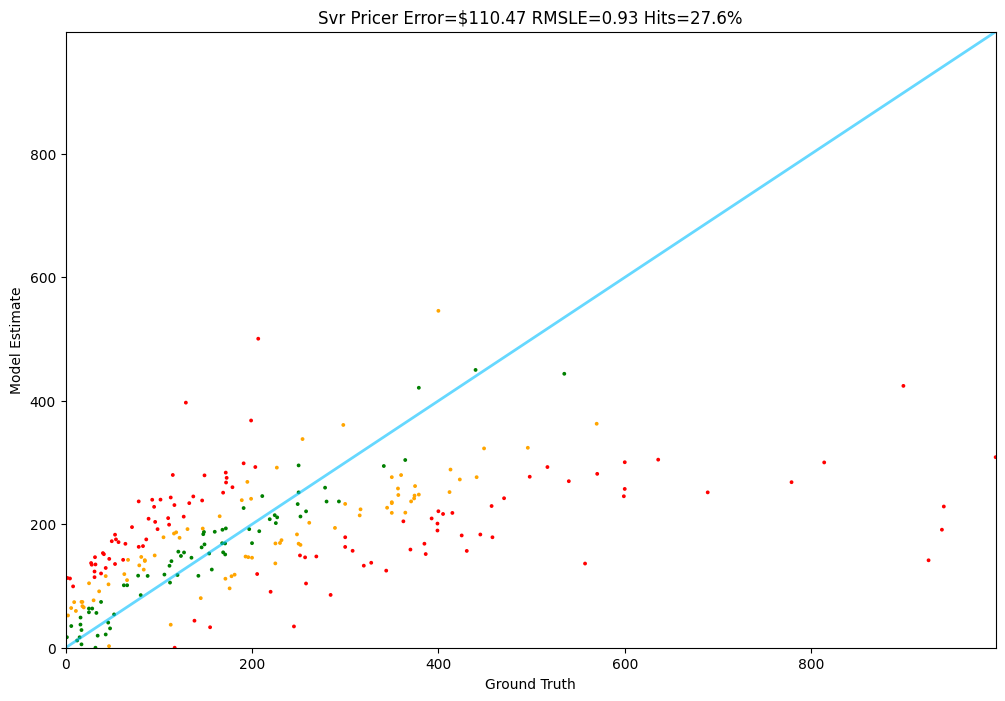

In [70]:
Tester.test(svr_pricer)

In [ ]:
# And the powerful Random Forest regression

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(X_w2v, prices)

In [ ]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

In [ ]:
Tester.test(random_forest_pricer)